<a href="https://colab.research.google.com/github/pksvv/lang-transformers/blob/main/TF_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Data Preprocessing
* TF input pipeline
* Building and Training
* Making Predictions

# Dataset

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [ ]:
pip install kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
ls -alrth ~

total 64K
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf*
-r-xr-xr-x 1 root root 1.2K Jan  1  2000 .bashrc*
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
drwxr-xr-x 3 root root 4.0K Dec  3 14:33 .gsutil/
drwxr-xr-x 5 root root 4.0K Dec 16 14:10 .ipython/
drwx------ 1 root root 4.0K Dec 16 14:10 .local/
drwx------ 2 root root 4.0K Dec 16 14:10 .jupyter/
drwxr-xr-x 1 root root 4.0K Dec 16 14:10 .config/
drwxr-xr-x 4 root root 4.0K Dec 16 14:11 .npm/
drwxr-xr-x 1 root root 4.0K Dec 16 14:13 .cache/
drwxr-xr-x 1 root root 4.0K Dec 31 08:07 ../
drwxr-xr-x 2 root root 4.0K Dec 31 08:07 .keras/
drwxr-xr-x 2 root root 4.0K Dec 31 08:08 .kaggle/
drwx------ 1 root root 4.0K Dec 31 08:08 ./


In [3]:
mkdir ~/.kaggle

In [5]:
mv ~/kaggle.json ~/.kaggle/kaggle.json

In [6]:
ls ~/.kaggle

kaggle.json


In [7]:
import kaggle

In [8]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [9]:
api = KaggleApi()

In [10]:
api.authenticate()

In [11]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip',
                              path='./')

api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip',
                              path='./')

100%|██████████| 494k/494k [00:00<00:00, 47.4MB/s]

100%|██████████| 1.28M/1.28M [00:00<00:00, 107MB/s]

In [12]:
ls ./

sample_data/  test.tsv.zip  train.tsv.zip


In [13]:
import zipfile

with zipfile.ZipFile('./test.tsv.zip','r') as zipref:
  zipref.extractall('./')

with zipfile.ZipFile('./train.tsv.zip','r') as zipref:
  zipref.extractall('./')

In [14]:
import pandas as pd

df = pd.read_csv('./train.tsv',sep='\t')

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [15]:
df['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [17]:
df.drop_duplicates(subset=['SentenceId'],keep='first')

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


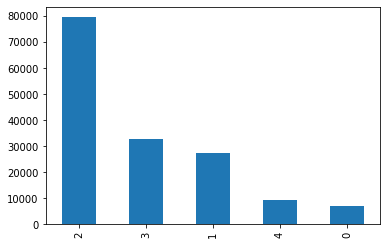

In [18]:
df['Sentiment'].value_counts().plot(kind='bar')

In [19]:
seq_len=512
num_samples=len(df)
num_samples,seq_len

(156060, 512)

In [20]:
pip install transformers

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 49.7 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 3.3 MB 46.9 MB/s 
     |████████████████████████████████| 61 kB 407 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [21]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
tokens = tokenizer(df['Phrase'].tolist(),max_length=seq_len,
                   truncation=True,padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np')

In [23]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [24]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [25]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [26]:
tokens['token_type_ids']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
import numpy as np
with open('movie-xids.npy','wb') as f:
  np.save(f,tokens['input_ids'])

with open('movie-xmasks.npy','wb') as f:
  np.save(f,tokens['attention_mask'])

In [29]:
ls -larth

total 1.3G
drwxr-xr-x 4 root root 4.0K Dec  3 14:33 .config/
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data/
drwxr-xr-x 1 root root 4.0K Dec 31 18:00 ../
-rw-r--r-- 1 root root 495K Dec 31 18:00 test.tsv.zip
-rw-r--r-- 1 root root 1.3M Dec 31 18:00 train.tsv.zip
-rw-r--r-- 1 root root 3.3M Dec 31 18:00 test.tsv
-rw-r--r-- 1 root root 8.1M Dec 31 18:00 train.tsv
drwxr-xr-x 1 root root 4.0K Dec 31 18:02 ./
-rw-r--r-- 1 root root 610M Dec 31 18:03 movie-xids.npy
-rw-r--r-- 1 root root 610M Dec 31 18:03 movie-xmasks.npy


# Creating Labels

In [30]:
arr = df['Sentiment'].values

In [31]:
arr.max()+1

5

In [32]:
labels = np.zeros((num_samples,arr.max()+1))

labels.shape

(156060, 5)

In [33]:
## 2 = [0,0,1,0,0]

## 4 = [0,0,0,0,1]

In [34]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [35]:
labels[np.arange(num_samples),arr]=1

In [36]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [37]:
with open('movie-labels.npy','wb') as f:
  np.save(f,labels)

In [38]:
ls

movie-labels.npy  movie-xmasks.npy  test.tsv      train.tsv
movie-xids.npy    sample_data/      test.tsv.zip  train.tsv.zip


In [39]:
with open('movie-xids.npy','rb') as  f:
  Xids = np.load(f,allow_pickle=True)

with open('movie-xmasks.npy','rb') as  f:
  Xmask = np.load(f,allow_pickle=True)

with open('movie-labels.npy','rb') as  f:
  labels = np.load(f,allow_pickle=True)

In [41]:
Xids.shape

(156060, 512)

In [42]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [43]:
import tensorflow as tf

In [44]:
dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))

In [45]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [ ]:
{input_ids,attention_mask},outputs

In [49]:
def map_func(input_ids,masks,labels):
  return {'input_ids':input_ids,
          'attention_mask':masks},labels

In [50]:
dataset = dataset.map(map_func)

In [51]:
dataset

<MapDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>